registration with template

In [ ]:
import os

os.environ['PATH'] += ':/opt/ANTs/bin' # ensure the ANTs binaries are in $PATH
os.environ['ANTSPATH'] = '/opt/ANTs/bin/'

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

images_dir = '/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_images/'
output_dir = '/home/jaimebarranco/Desktop/eye_model/combined/output/registrationToTemplate/'
template = '/home/jaimebarranco/Desktop/eye_model/combined/output/templateConstruction/template0.nii.gz'

for file in sorted(glob.glob(images_dir + '*_cropped.nii.gz')):
        filename = os.path.basename(file)
        output_folder = output_dir + filename.split("_")[0] + '/'
        # print(output_folder)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        ## antsRegistrationSyNQuick # s: rigid + affine + deformable syn (3 stages)
        command1 = 'antsRegistrationSyNQuick.sh -d 3' + \
        ' -m ' + file                                 + \
        ' -f ' + template                             + \
        ' -t ' + 's'                                  + \
        ' -o ' + output_folder                        + \
        ' -n ' + '16'
        # print(command1)
        os.system(command1)


copy atlas' labels to input folder

In [ ]:
import shutil

input_atlas_labels_dir = "/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/non_labeled_dataset_nifti_reg_2/"
output_atlas_labels_dir = "/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/atlas/"

for file in sorted(glob.glob(input_atlas_labels_dir + '*/labels.nii.gz', recursive=True)):
    filename = os.path.basename(file)
    # print(file.split("/")[-2])
    shutil.copy(file, os.path.join(output_atlas_labels_dir, f'{file.split("/")[-2]}.nii.gz'))

copy nnunet labels to input folder

In [ ]:
import shutil

input_nnunet_labels_dir = "/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/no_postprocessing_cropped_alligned/"
output_nnunet_labels_dir = "/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/nnunet/"

for file in sorted(glob.glob(input_nnunet_labels_dir + '*.nii.gz', recursive=True)):
    filename = os.path.basename(file)
    # print(filename.split("_")[0])
    shutil.copy(file, os.path.join(output_nnunet_labels_dir, f'{filename.split("_")[0]}.nii.gz'))

apply transform to labels from subjects to template (direct transform)

In [ ]:
labels_dir = '/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/nnunet/' # atlas or nnunet
output_dir = '/home/jaimebarranco/Desktop/eye_model/combined/output/registrationToTemplate/'
template = '/home/jaimebarranco/Desktop/eye_model/combined/output/templateConstruction/template0.nii.gz'

for file in sorted(glob.glob(labels_dir + '*.nii.gz')):
        filename = os.path.basename(file)
        output_folder = output_dir + filename.split(".")[0] + '/'
        # print(output_folder)
        
        # antsApplyTransforms with inverse transform to get the template labels into subject space
        command2 = 'antsApplyTransforms -d 3 ' + \
        ' -i ' +  file + \
        ' -r ' +  template + \
        ' -t ' + output_folder + '1Warp.nii.gz' + \
        ' -t ' + output_folder + '0GenericAffine.mat' + \
        ' -n ' + 'MultiLabel' + \
        ' -o ' +  output_folder + 'labels_nnunet.nii.gz' + \
        ' --float 0 --verbose 1'
        # print(command2)
        os.system(command2)

        # Dealing with files in that folder
        # for f in glob.glob(output_image_path + 'labels.nii.gz'):
        #     os.remove(f)

probability per voxel to belong to a certain structure of the eye
---

array generation

In [ ]:
import nibabel as nb
import numpy as np
import os
import glob

labels_dir = '/home/jaimebarranco/Desktop/eye_model/combined/output/registrationToTemplate/'

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + '*/labels_atlas.nii.gz'))[0] # atlas or nnunet
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape  # (77, 95, 94)

In [ ]:
# (1210, 77, 95, 94) array generation
num_images = 1210
labels_matrix = np.empty((num_images, *image_shape))
for idx, file in enumerate(sorted(glob.glob(labels_dir + '*/labels_atlas.nii.gz'))): # atlas or nnunet
    sub = file.split("/")[-2] # str
    # print(idx)
    # print(file)
    # print(sub)
    labels = nb.load(file)
    # labels_shape = labels.shape
    # print(labels_shape)
    labels_data = labels.get_fdata()
    labels_matrix[idx] = labels_data

voxel_arrays = np.moveaxis(labels_matrix, 0, -1)
print(voxel_arrays.shape)  # (77, 95, 94, 1210)

compute the probabilities

In [ ]:
from collections import Counter
from scipy import stats

# matrices for most likely tissue (median) and probability of that tissue (divided by number of images)
stat_matrix = np.empty(image_shape)
prob_matrix = np.empty(image_shape)

# mode extended and probability calculation for each voxel
for x in range(image_shape[0]):
    for y in range(image_shape[1]):
        for z in range(image_shape[2]):
            voxel_values = voxel_arrays[x, y, z, :]
            freq = Counter(voxel_values)
            voxel_frequencies = freq.most_common() # [(label, frequency), ...]
            # [0][0] most frequent value, [1][0] second most frequent value
            # [0][1] most frequent frequency, [1][1] second most frequent frequency
            voxel_value = voxel_frequencies[1][0] if voxel_frequencies[0][0] == 0 and len(voxel_frequencies) > 1 else voxel_frequencies[0][0] # "extended" mode values
            voxel_value_frequency = voxel_frequencies[1][1] if voxel_frequencies[0][0] == 0 and len(voxel_frequencies) > 1 else voxel_frequencies[0][1]
            # voxel_mode_ext = stats.mode(voxel_values)[0] # or voxel_mode_extended = voxel_frequencies[0][0] # most frequent value --> for max_prob_map
            stat_matrix[x, y, z] = voxel_value
            prob_mode = voxel_value_frequency / num_images
            prob_matrix[x, y, z] = prob_mode

save the matrices

In [ ]:
# save matrices
np.save('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/atlas/mode_ext_matrix.npy', stat_matrix)
np.save('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/atlas/mode_ext_prob_matrix.npy', prob_matrix)

max prob map (majority voting)
---

load matrices

In [ ]:
import numpy as np

# load matrices
stat_matrix = np.load('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/atlas/mode_ext_matrix.npy')
prob_matrix = np.load('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/atlas/mode_ext_prob_matrix.npy')

print("stat matrix: ", stat_matrix.shape)
print("probability matrix: ", prob_matrix.shape)

save nifti

In [ ]:
import nibabel as nb

# save median matrix as nifti
mode_nifti = nb.Nifti1Image(stat_matrix, sample_image.affine, sample_image.header)
nb.save(mode_nifti, '/home/jaimebarranco/Desktop/eye_model/combined/output/maps/atlas/mode_ext_max_prob_map.nii.gz')

probability map
---

load matrices

In [10]:
import numpy as np

# load matrices
stat_matrix = np.load('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/nnunet/mode_ext_matrix.npy')
prob_matrix = np.load('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/nnunet/mode_ext_prob_matrix.npy')

print("stat matrix: ", stat_matrix.shape)
print("probability matrix: ", prob_matrix.shape)

stat matrix:  (77, 95, 94)
probability matrix:  (77, 95, 94)


select colors

In [2]:
import matplotlib.colors as mcolors
# matplotlib (https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py)

# define colors for the different labels (tissues)
colors = {
    1: 'red',  # lens | tab:red
    2: 'green',  # globe | lime
    3: 'blue',  # optic nerve | tab:blue
    4: 'yellow',  # intraconal fat | yellow
    5: 'cyan',  # extraconal fat | cyan
    6: 'magenta',  # lateral rectus muscle | magenta
    7: 'orange',  # medial rectus muscle | ivory
    8: 'purple',  # inferior rectus muscle | tab:purple
    9: 'brown',  # superior rectus muscle | chocolate
}

# colors to rgb using matplotlib
rgb_colors = {}
for key, value in colors.items():
    rgb_colors[key] = mcolors.to_rgb(value) # no alpha channel
print("rgb: ", rgb_colors)

# colors to hsv
hsv_colors = {}
for key, value in rgb_colors.items():
    hsv_colors[key] = mcolors.rgb_to_hsv(value)
print("hsv: ", hsv_colors)

rgb:  {1: (1.0, 0.0, 0.0), 2: (0.0, 0.5019607843137255, 0.0), 3: (0.0, 0.0, 1.0), 4: (1.0, 1.0, 0.0), 5: (0.0, 1.0, 1.0), 6: (1.0, 0.0, 1.0), 7: (1.0, 0.6470588235294118, 0.0), 8: (0.5019607843137255, 0.0, 0.5019607843137255), 9: (0.6470588235294118, 0.16470588235294117, 0.16470588235294117)}
hsv:  {1: array([0., 1., 1.]), 2: array([0.33333333, 1.        , 0.50196078]), 3: array([0.66666667, 1.        , 1.        ]), 4: array([0.16666667, 1.        , 1.        ]), 5: array([0.5, 1. , 1. ]), 6: array([0.83333333, 1.        , 1.        ]), 7: array([0.10784314, 1.        , 1.        ]), 8: array([0.83333333, 1.        , 0.50196078]), 9: array([0.        , 0.74545455, 0.64705882])}


multiply color "intensity" by the probability of the voxel

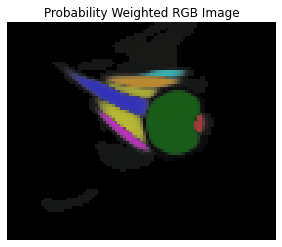

In [20]:
import matplotlib.pyplot as plt

# Initialize the HSV matrix with the same size as stat_matrix and an extra dimension for the 3 channels
hsv_image = np.zeros((*stat_matrix.shape, 3))

# Assign HSV values to each voxel based on its label in the stat_matrix
for label, hsv_value in hsv_colors.items():
    hsv_image[stat_matrix == label] = hsv_value

# Define the transformation functions
def no_transform(matrix):
    return matrix

def log_transform(matrix, correction=1):
    return np.log(matrix + correction)

def sigmoid_transform(matrix, k=1):
    return 1 / (1 + np.exp(-k * matrix))

def exp_inv_transform(matrix, k=1):
    return 1 - np.exp(-k * matrix)

# Choose the transformation function and correction parameter
transformation = 'log'  # Change to 'sigmoid' or 'exp_inv' as needed
correction_value = 1.1    # Adjust this value as needed

# Apply the transformation
if transformation == 'no':
    transformed_matrix = no_transform(prob_matrix)
elif transformation == 'log':
    transformed_matrix = log_transform(prob_matrix, correction=correction_value)
elif transformation == 'sigmoid':
    transformed_matrix = sigmoid_transform(prob_matrix, k=correction_value)
elif transformation == 'exp_inv':
    transformed_matrix = exp_inv_transform(prob_matrix, k=correction_value)
else:
    raise ValueError("Invalid transformation. Choose 'log', 'sigmoid', or 'exp_inv'.")

# Adjust Saturation (S) and Value (V) based on the probability
hsv_image[..., 1] = np.multiply(hsv_image[..., 1], transformed_matrix)  # Adjust Saturation
hsv_image[..., 2] = np.multiply(hsv_image[..., 2], transformed_matrix)  # Adjust Value

# Convert the adjusted HSV image to RGB
rgb_image = mcolors.hsv_to_rgb(hsv_image)
sample_rgbimage = rgb_image[..., 67, :]

# To visualize a single slice (e.g., the first slice in the third dimension)
plt.imshow(rgb_image[..., 67, :], interpolation='nearest')
plt.title('Probability Weighted RGB Image')
plt.axis('off')
plt.show()

# Save the RGB image if necessary
# plt.imsave('weighted_rgb_image.png', rgb_image[..., 0, :])    

visualize with a Z-axis slider 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Function to create a 2D plot for a specific z slice
def plot_2d_slice(rgb_image, z_index):
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image[:, :, z_index], interpolation='nearest')
    plt.title(f'Slice at z = {z_index}')
    plt.axis('off')
    plt.show()

# Interactive function to update the plot based on slider value
def update_plot(z_index):
    plot_2d_slice(rgb_image, z_index)

# Create the slider widget
z_slider = widgets.IntSlider(min=0, max=rgb_image.shape[2]-1, step=1, value=0, description='Z-axis')

# Use interact to update the plot when the slider value changes
interact(update_plot, z_index=z_slider)

interactive(children=(IntSlider(value=0, description='Z-axis', max=93), Output()), _dom_classes=('widget-inter…

<function __main__.update_plot(z_index)>

save rgb image as .npy

In [22]:
# Save the entire rgb_image array to a .npy file
np.save('/home/jaimebarranco/Desktop/eye_model/combined/output/maps/nnunet/mode_ext_prob_map.npy', rgb_image)

overlap + slider

In [23]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Load the template image
template_path = '/home/jaimebarranco/Desktop/eye_model/combined/output/templateConstruction/template0.nii.gz'
template_img = nb.load(template_path)
template_data = template_img.get_fdata()

# Load the prob_map from prob_map_path
prob_map_path = '/home/jaimebarranco/Desktop/eye_model/combined/output/maps/nnunet/mode_ext_prob_map.npy'
prob_map = np.load(prob_map_path)

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1)

# Create a function to plot both images overlapped
def plot_images(alpha_prob_map, alpha_overlay, z_index):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Rotate template image
    rotated_template = rotate_image(template_data)

    # Rotate prob_map
    rotated_prob_map = rotate_image(prob_map)

    # Plot the rotated template image
    ax.imshow(rotated_template[:, :, z_index], cmap='gist_gray', interpolation='none', alpha=1)

    # Extract RGB channels from prob_map
    rgb_channels = rotated_prob_map[..., z_index, :]

    # Normalize RGB channels for intensity adjustment
    rgb_channels_norm = rgb_channels / np.max(rgb_channels)

    # Apply intensity adjustment to prob_map
    adjusted_prob_map = rgb_channels_norm * alpha_prob_map

    # Overlay the prob_map with adjustable transparency
    ax.imshow(adjusted_prob_map, alpha=alpha_overlay)

    # Set title and turn off axis
    ax.set_title('Overlayed Image')
    ax.axis('off')

    # Show the plot
    plt.show()

# Create sliders for adjusting alpha of probability map and overlay, and z-axis slice
alpha_prob_map_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=1, description='Alpha Prob Map')
alpha_overlay_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Overlay')
z_slider = widgets.IntSlider(min=0, max=template_data.shape[2] - 1, step=1, value=template_data.shape[2] // 2, description='Z-axis')

# Create an interactive plot
interact(plot_images, alpha_prob_map=alpha_prob_map_slider, alpha_overlay=alpha_overlay_slider, z_index=z_slider)


interactive(children=(FloatSlider(value=1.0, description='Alpha Prob Map', max=1.0, step=0.05), FloatSlider(va…

<function __main__.plot_images(alpha_prob_map, alpha_overlay, z_index)>